In [ ]:
#!/usr/bin/env python

'''
    RadCLIP Clustering Models
'''

__author__ = "Andrew D'Amico"
__copyright__ = "Copyright 2023"
__credits__ = ["Andrew D'Amico", "Christoper Alexander", "Katya Nosulko", "Vivek Chamala", "Matthew Conger"]
__license__ = ""
__version__ = "0.0.1"
__maintainer__ = "Andrew Damico"
__email__ = "andrew.damico@u.northwestern.edu"

In [1]:
import random

import numpy as np
import pandas as pd
from kneed import KneeLocator
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm


# K-Means Embedding Clustering

## Load Data Set

In [ ]:
dataset = pd.read_csv('refined_dataset2.csv')
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

## Function to Create Embeddings or Load Previous Embeddings

In [3]:
def save_embeddings(
        df=None,
        model=None,
        column=None,
        save_name="dataset_embeddings",
        save=True,
        load_saved=False,
        as_json=True
):
    def get_embeddings(text, model=model, padding=True):

        inputs = tokenizer(text, max_length=77, padding='max_length', truncation=True, return_tensors='pt', )

        container = {
            'value': text,
            'tokens': inputs,
            'features': model.get_text_features(**inputs)
        }

        return container

    def from_np_array(array_string):
        array_string = ','.join(array_string.replace('[ ', '[').split())
        return np.array(ast.literal_eval(array_string))

    if load_saved:

        if as_json:
            corpus = pd.read_json(f'{save_name}.json')

        #Load from CSV. Note that this is a long process due to the conversation
        else:
            corpus = pd.read_csv(save_name, converters={'embeddings': from_np_array})
        #Load the corpus

    else:
        corpus = df.copy()  #[:10].copy()

        #Create embeddings container
        corpus['embeddings'] = None

        for row in tqdm(range(len(corpus))):
            try:
                tensor = get_embeddings(df[column][row], model=model)['features'][0].detach().numpy()
                corpus['embeddings'][row] = tensor
            except Exception as e:
                print(e)

        if save:
            if as_json:
                corpus.to_json(f'{save_name}.json')
            else:
                corpus.to_csv(f'{save_name}.csv')

    return (corpus)

### Create Corpus

In [4]:
corpus = save_embeddings(
    #df = dataset, 
    #model = model,
    column="value",
    save_name="Datasets/refined_dataset4",
    as_json=True,
    load_saved=True,
    save=True
)

### Load Embeddings to List for Clustering

In [5]:
kmeans_df = corpus["embeddings"].values.tolist()
len(kmeans_df)

385463

# Function to Determine Optimal K

In [10]:
def elbow_method(matrix, min_k, max_k, sample: int = None, seed=None, knee=True, inertia=20):
    distortions = []
    silhouettes = []

    # Set Seed
    if not seed:
        seed = random.randrange(10000000)

    print(f'Seed: {seed}')

    K = range(min_k, max_k + 1)

    if sample:
        matrix = random.sample(matrix, sample)

    for k in tqdm(K):
        model = KMeans(k, random_state=seed, n_init=inertia)
        labels = model.fit_predict(matrix)
        silhouette_avg = silhouette_score(matrix, labels)
        silhouettes.append(silhouette_avg)
        distortions.append(model.inertia_)

    def bestk_plot(axis, x, y, color, draw_knee=True, curve=None, direction=None, twinx=None):
        if twinx:
            ax = axis.twinx()
        else:
            ax = axis
            #ax.set_xlabel(argname('x'))
        #ax.set_ylabel(argname('y'), color=color)
        #ax.plot(x, y, color=color, label=argname('y'))
        ax.plot(x, y, color=color)
        ax.set_yticks(np.linspace(axis.get_ybound()[0], axis.get_ybound()[1], 5))
        ax.tick_params(axis='y', labelcolor=color)

        if draw_knee:
            # https://kneed.readthedocs.io/en/stable/parameters.html
            kneedle_interp1d = KneeLocator(
                x=x,
                y=y,
                curve=curve,
                direction=direction,
                online=True,
                interp_method="interp1d",  #Valid arguments are “interp1d” and “polynomial”.
                polynomial_degree=7  #Default
            )

            kneedle_polynomial = KneeLocator(
                x=x,
                y=y,
                curve=curve,
                direction=direction,
                online=True,
                interp_method="polynomial",  #Valid arguments are “interp1d” and “polynomial”.
                polynomial_degree=7  #Default
            )

            # print (kneedle_interp1d.knee)

            ax.axvline(kneedle_interp1d.knee, color="red", linestyle="-", label=f'Interp1d')
            print(f'Knee for Interp1d: {kneedle_interp1d.knee}')
            ax.axvline(kneedle_polynomial.knee, color="blue", linestyle="--", label=f'polynomial')
            print(f'Knee for Polynomial: {kneedle_polynomial.knee}')

        return ax

    fig, ax1 = plt.subplots()
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method with optimal k')

    ax1 = bestk_plot(ax1, K, distortions, 'black', draw_knee=True, curve='convex', direction='decreasing')
    #ax2 = bestk_plot(ax1, K, silhouettes, 'tab:blue', True,'concave', 'increasing', twinx=True)
    ax3 = ax1.twinx()
    #plt.text(0.5, 0.5, 'matplotlib', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
    plt.xticks(K)

    # Shrink current axis by 20%
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    fig.tight_layout()
    # Put a legend to the right of the current axis
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    #text(0.5, 1, f'Seed: {seed}', horizontalalignment='left', verticalalignment='bottom', transform=fig.transFigure)

    #plt.legend(location='best')

    return plt.show()

#elbow_method(TFIDF_matrix, 2, 7)

Seed: 4929643


  0%|          | 0/99 [00:00<?, ?it/s]

Knee for Interp1d: 41
Knee for Polynomial: 25


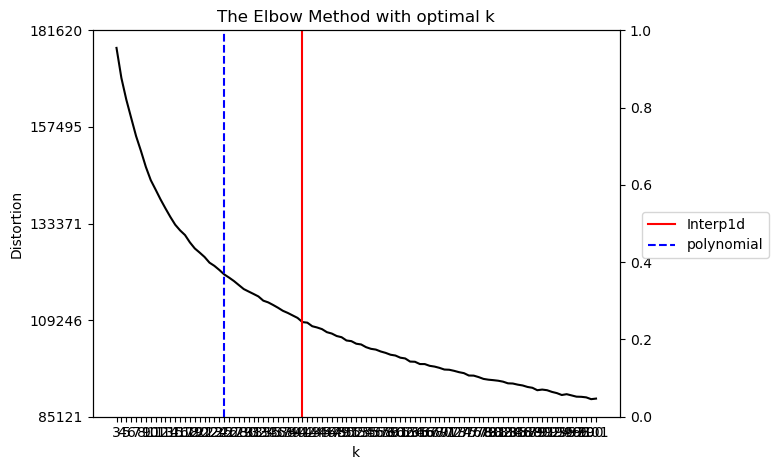

In [11]:
elbow_method(
    matrix=kmeans_df,
    inertia=20,
    sample=10000,
    min_k=3,
    max_k=101
)

# Create Cluster Models and Classes from Clusters

In [8]:
def run_clustering(
        corpus,
        random=1989,
        n_init=10,  #Default
        graph=True,
        name="dbscan_clusters",
        n_clusters=8,  #default
        model=None,
        sample=True,
        save=True,
        n=10000,
        s=50,
        eps=None,
        min_samples=5
):
    def tag_clusters(df):

        labels = model.labels_

        Dictionary = {'Sentence': corpus.index, 'Cluster': labels.tolist(), 'text': corpus['value']}
        frame = pd.DataFrame(Dictionary, columns=['Cluster', 'Sentence', 'text'])

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        print("Estimated number of clusters: %d" % n_clusters_)
        print("Estimated number of noise points: %d" % n_noise_)

        if save:
            frame.sort_values('Cluster').to_csv(name + '.csv')

        return (frame.sort_values('Cluster'), n_clusters_)

    clusters = None
    #n_clusters = None

    #Determine if we are clustering a sample or the full set
    if sample:
        corpus = corpus.sample(n)

    df = corpus["embeddings"].values.tolist()

    # Draw Nearest Neighbor Graph
    if graph:
        neighbors = NearestNeighbors(n_neighbors=min_samples)
        neighbors_fit = neighbors.fit(df)
        distances, indices = neighbors_fit.kneighbors(df)

        distances = np.sort(distances, axis=0)
        distances = distances[:, 1]
        distances = distances[distances > 1]
        plt.plot(distances)

        #####
        curve = "convex"
        direction = "increasing"
        s = s
        polydeg = 4
        knee = None

        x = range(len(distances))
        y = distances

        # https://kneed.readthedocs.io/en/stable/parameters.html
        kneedle_interp1d = KneeLocator(x, y,
                                       S=s,
                                       curve=curve,
                                       direction=direction,
                                       online=True,
                                       interp_method="interp1d",  #Valid arguments are “interp1d” and “polynomial”.
                                       polynomial_degree=polydeg  #Default
                                       )

        kneedle_polynomial = KneeLocator(x, y,
                                         S=s,
                                         curve=curve,
                                         direction=direction,
                                         online=True,
                                         interp_method="polynomial",  #Valid arguments are “interp1d” and “polynomial”.
                                         polynomial_degree=polydeg  #Default
                                         )

        plt.axvline(kneedle_interp1d.knee, color="red", linestyle="-", label=f'Interp1d')
        plt.axvline(kneedle_polynomial.knee, color="blue", linestyle="--", label=f'polynomial')

        try:
            knee = np.interp(kneedle_polynomial.knee, x, y)
            plt.axhline(knee, color="green", linestyle="-", label=f'eps')
        except:
            plt.axhline(eps, color="green", linestyle="-", label=f'eps')

    ### Spectral Clustering
    if model == "spectral":

        model = SpectralClustering(
            n_clusters=n_clusters,
            random_state=random,
            n_init=n_init
        )

        model.fit(df)

        clusters, n_clusters = tag_clusters(df)


    ### K-means Clustering   
    elif model == "kmeans":

        model = KMeans(
            n_clusters=num_clusters,
            random_state=random,
            n_init=n_init
        )

        model.fit(df)

        clusters, n_clusters = tag_clusters(df)


    elif model == "dbscan":

        if knee == None:
            knee = eps

        model = DBSCAN(
            eps=knee,
            min_samples=min_samples
        )

        model.fit(df)

        clusters, n_clusters = tag_clusters(df)

    else:
        pass

    return (clusters, n_clusters)

Estimated number of clusters: 455
Estimated number of noise points: 54885


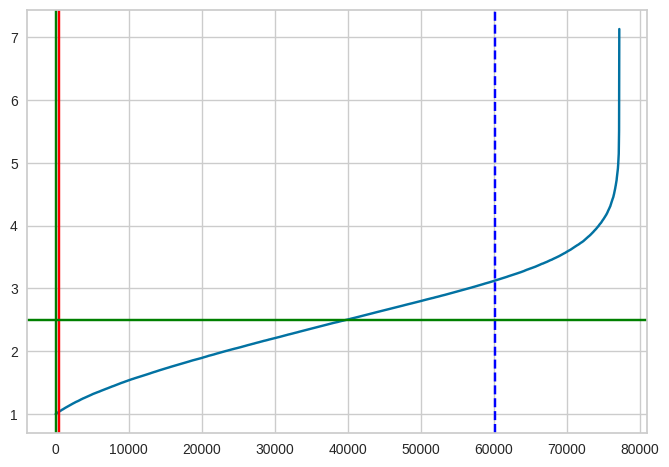

In [9]:
results, n_clusters = run_clustering(
    corpus,
    random=1989,
    n_clusters=8,
    graph=True,
    s=200,
    model="dbscan",  # spectral, dbscan, or kmeans
    name="dbscan_clusters_sample_3",
    sample=True,
    save=True,
    n=150000,
    eps=2.5,  #Manually override eps if no knee was previously found
    min_samples=10  #Min samples for dbscan cluster
)

# Perform EDA on Clusters

In [ ]:
for i in range(n_clusters):
    print(f'Cluster: {i}')
    print(results[results['Cluster'] == i].head())

In [131]:
results[results["Cluster"] == 12]

,Cluster,Sentence,text
237602,12,237602,findings were discussed with dr by dr the tele...
442992,12,442992,findings were discussed with dr by dr at am vi...
314358,12,314358,these findings were communicated with by at pm...
50012,12,50012,these findings were communicated via telephone...
